In [1]:
!pip install tensorflow numpy pandas ndjson matplotlib

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import ndjson
import matplotlib.pyplot as plt
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
# Define the file path
FILE_PATH = "C:/Users/Andrea Nelson/Downloads/QuickDrawDatasetSimplified/full_simplified_dog.ndjson"

def load_quickdraw_data(filepath, num_samples=10000):
    with open(filepath, 'r') as f:
        data = ndjson.load(f)

    drawings = [sample['drawing'] for sample in data[:num_samples]]
    
    # Convert to sequences of (x, y) deltas
    sequences = []
    for drawing in drawings:
        strokes = []
        for stroke in drawing:
            x, y = stroke[0], stroke[1]
            for i in range(1, len(x)):
                dx, dy = x[i] - x[i-1], y[i] - y[i-1]
                strokes.append([dx, dy])
        sequences.append(strokes)
    
    return sequences

# Load dataset
sequences = load_quickdraw_data(FILE_PATH)
print(f"Loaded {len(sequences)} samples from {FILE_PATH}")


Loaded 10000 samples from C:/Users/Andrea Nelson/Downloads/QuickDrawDatasetSimplified/full_simplified_dog.ndjson


In [9]:
MAX_SEQ_LEN = 200  # Limit sequence length
PAD_VALUE = 0

def preprocess_sequences(sequences, max_len=MAX_SEQ_LEN):
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post', dtype='float32', value=PAD_VALUE)
    return sequences

# Convert and pad sequences
X = preprocess_sequences(sequences)
y = np.roll(X, shift=-1, axis=1)  # Next stroke prediction


### Building of Transformer Model

In [11]:
# Define Position Encoding Layer (Added to handle sequence ordering)
class PositionEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, max_seq_len):
        super(PositionEncoding, self).__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.position_encodings = self.get_position_encoding()

    def get_position_encoding(self):
        position = np.arange(self.max_seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.d_model, 2) * -(np.log(10000.0) / self.d_model))
        position_encoding = np.zeros((self.max_seq_len, self.d_model))
        position_encoding[:, 0::2] = np.sin(position * div_term)
        position_encoding[:, 1::2] = np.cos(position * div_term)
        return tf.constant(position_encoding, dtype=tf.float32)

    def call(self, x):
        return x + self.position_encodings[:tf.shape(x)[1], :]

# Define Encoder Layer (Increased depth, added L2 regularization)
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, dropout_rate=0.1, l2_reg=0.01):
        super(TransformerEncoder, self).__init__()
        self.embedding = tf.keras.layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.position_encoding = PositionEncoding(d_model, 500)  # Max sequence length of 500
        self.encoder_layers = [
            tf.keras.layers.MultiHeadAttention(num_heads, d_model // num_heads) for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        x = self.embedding(x)
        x = self.position_encoding(x)  # Add position encoding
        for layer in self.encoder_layers:
            x = self.norm(layer(x, x) + x)  # Residual connection
        return self.dropout(x)

# Define Decoder Layer (Increased depth, added L2 regularization)
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, dropout_rate=0.1, l2_reg=0.01):
        super(TransformerDecoder, self).__init__()
        self.embedding = tf.keras.layers.Dense(d_model, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.decoder_layers = [
            tf.keras.layers.MultiHeadAttention(num_heads, d_model // num_heads) for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.final_layer = tf.keras.layers.Dense(2)  # Predict (dx, dy)

    def call(self, x, enc_output):
        x = self.embedding(x)
        for layer in self.decoder_layers:
            x = self.norm(layer(x, enc_output) + x)  # Residual connection
        return self.final_layer(self.dropout(x))

# Full Model Setup
class GuidedDrawingModel(tf.keras.Model):
    def __init__(self, num_layers=4, d_model=128, num_heads=8, dff=512):
        super(GuidedDrawingModel, self).__init__()
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, dff)
        self.decoder = TransformerDecoder(num_layers, d_model, num_heads, dff)

    def call(self, x):
        enc_output = self.encoder(x)  # Encoder processes input strokes
        dec_output = self.decoder(x, enc_output)  # Decoder generates predictions
        return dec_output

# Instantiate the model
model = GuidedDrawingModel()

In [13]:
# Learning Rate Scheduler and Early Stopping
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.96, staircase=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Compile model with MSE loss and MAE metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

In [15]:
# Train model with callbacks
history = model.fit(X, y, epochs=50, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 158s 992ms/step - loss: 80.4634 - mae: 3.4870 - val_loss: 68.9064 - val_mae: 3.0319
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 140s 992ms/step - loss: 69.7779 - mae: 2.9981 - val_loss: 68.2268 - val_mae: 2.9822
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 139s 987ms/step - loss: 69.6460 - mae: 2.9949 - val_loss: 68.0480 - val_mae: 3.0647
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 138s 976ms/step - loss: 67.8641 - mae: 2.9881 - val_loss: 67.3262 - val_mae: 3.0527
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 138s 979ms/step - loss: 68.7865 - mae: 2.9850 - val_loss: 67.4453 - val_mae: 3.0048
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 135s 957ms/step - loss: 66.8367 - mae: 2.9548 - val_loss: 66.9368 - val_mae: 2.9963
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 137s 969ms/step - loss: 67.7873 - mae: 2.9662 - val_loss: 67.0848 - val_mae: 2.9804
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 138s 978ms/step - loss: 67.9962 - mae: 2.9653 - val_loss: 66.2482 - val_mae: 2.9106
Epoch 9/

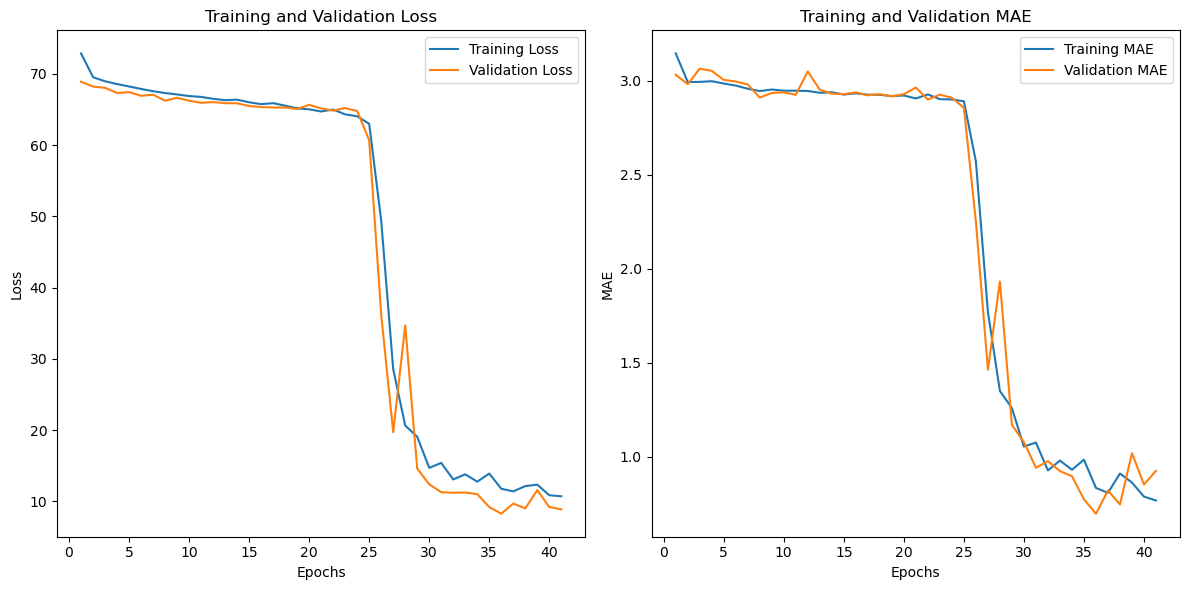

In [27]:
import matplotlib.pyplot as plt

# Extract the history of loss and metrics
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
mae = history_dict['mae']
val_mae = history_dict['val_mae']
epochs = range(1, len(loss) + 1)

# Plot loss
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, label='Training MAE')
plt.plot(epochs, val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Prediction Function (Diverse Output using Dropout)
def predict_next_stroke(model, input_strokes, max_len=500, dropout_rate=0.2):
    input_strokes = preprocess_sequences([input_strokes], max_len)
    # Enable dropout during inference for diverse predictions
    prediction = model(input_strokes, training=True)
    return prediction[0][-1]  # Get the last stroke prediction

# Example prediction
sample_stroke = sequences[0][:10]  # Take first 10 strokes of a sample
next_stroke = predict_next_stroke(model, sample_stroke)
print("Predicted next stroke (dx, dy):", next_stroke)


Predicted next stroke (dx, dy): tf.Tensor([-0.85620534  0.24681517], shape=(2,), dtype=float32)


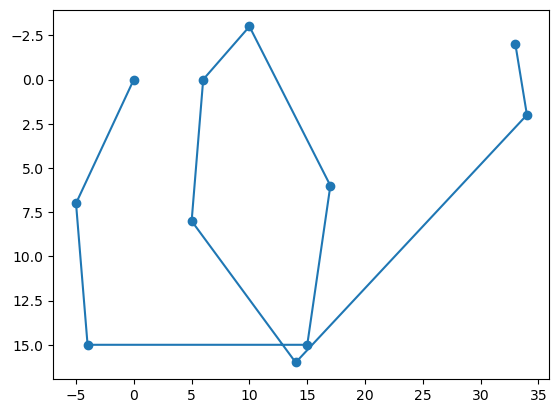

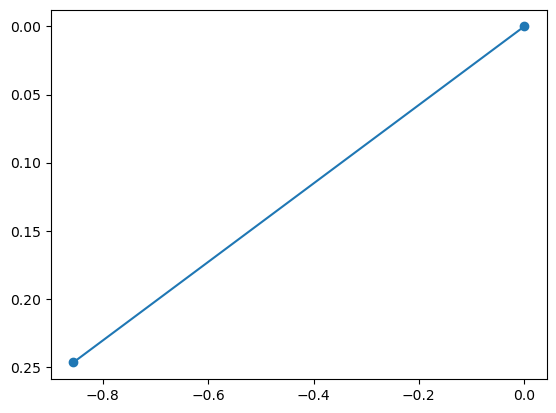

In [17]:
# Visualization of strokes (Original + Predicted)
def plot_stroke_sequence(stroke_sequence):
    x, y = [0], [0]
    for dx, dy in stroke_sequence:
        x.append(x[-1] + dx)
        y.append(y[-1] + dy)
    plt.plot(x, y, marker='o')
    plt.gca().invert_yaxis()
    plt.show()

# Visualize the actual and predicted strokes
plot_stroke_sequence(sample_stroke)
plot_stroke_sequence([next_stroke])  # Predicted strokes

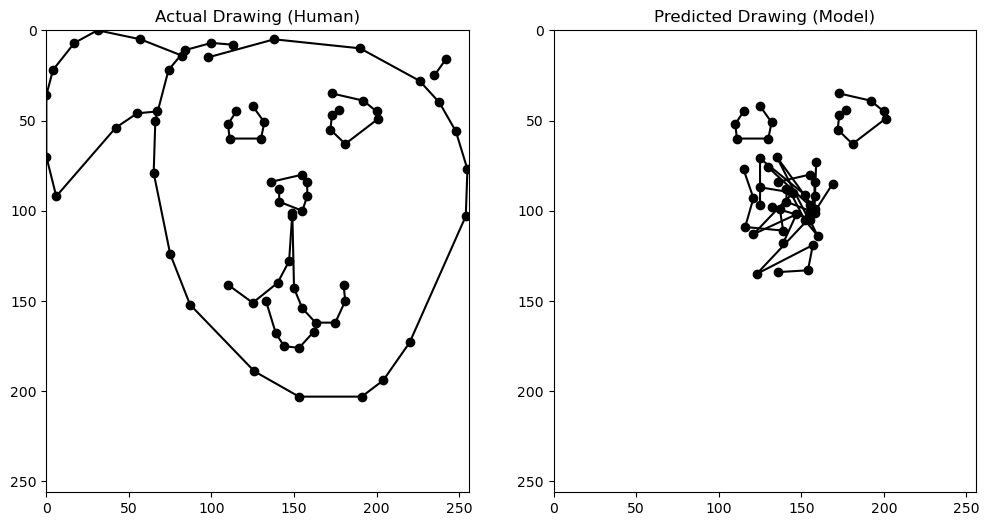

In [19]:
# Load actual drawing from dataset (modify file path as needed)
file_path = "C:/Users/Andrea Nelson/Downloads/QuickDrawDatasetSimplified/full_simplified_dog.ndjson"

# Load one drawing
with open(file_path, "r") as f:
    first_line = f.readline()  # Read the first drawing
    data = json.loads(first_line)  # Convert from JSON format

actual_strokes = data["drawing"]  # Extract stroke data

# Extract the first 3 strokes as input
input_strokes = actual_strokes[:3]

# Preprocess the input strokes to match the model's expected input format
def preprocess_strokes(strokes):
    """Convert strokes into the format expected by the model."""
    x = []
    y = []
    for stroke in strokes:
        x.extend(stroke[0])
        y.extend(stroke[1])
    return np.array([x, y]).T  # (num_points, 2)

# Prepare input for the model
model_input = preprocess_strokes(input_strokes)

# Reshape input to match the model's batch input shape
model_input = np.expand_dims(model_input, axis=0)  # (batch_size, sequence_length, 2)

# 🔹 Use the model to predict next strokes
def predict_next_strokes(model, input_strokes, num_predictions=5):
    """
    Predict the next strokes using the trained model.
    """
    model_input = preprocess_strokes(input_strokes)
    model_input = np.expand_dims(model_input, axis=0)  # (batch_size, sequence_length, 2)
    
    # Get the model's prediction (next stroke positions)
    predicted_strokes = model(model_input)  # (batch_size, sequence_length, 2)
    
    # Convert predicted strokes to the format of (x, y) coordinates
    predicted_strokes = predicted_strokes.numpy().flatten()
    predicted_x = predicted_strokes[::2]
    predicted_y = predicted_strokes[1::2]
    
    # Break the predicted strokes into individual stroke segments
    strokes = []
    for i in range(0, len(predicted_x), 5):  # Assuming each stroke has 5 points
        strokes.append([predicted_x[i:i+5], predicted_y[i:i+5]])
    
    return strokes

# Get model-generated strokes
predicted_strokes = predict_next_strokes(model, input_strokes, num_predictions=len(actual_strokes)-3)

# Combine input strokes and predicted strokes for the final output
final_predicted_drawing = input_strokes + predicted_strokes

# Function to plot strokes
def plot_drawing(ax, strokes, title):
    ax.set_xlim(0, 256)
    ax.set_ylim(0, 256)
    ax.invert_yaxis()  # Match dataset drawing orientation
    for stroke in strokes:
        ax.plot(stroke[0], stroke[1], marker='o', color='black')
    ax.set_title(title)

# 🔹 Visualizing the Actual vs Predicted Drawings
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Actual Drawing
plot_drawing(axs[0], actual_strokes, "Actual Drawing (Human)")

# Plot Predicted Drawing
plot_drawing(axs[1], final_predicted_drawing, "Predicted Drawing (Model)")

plt.show()

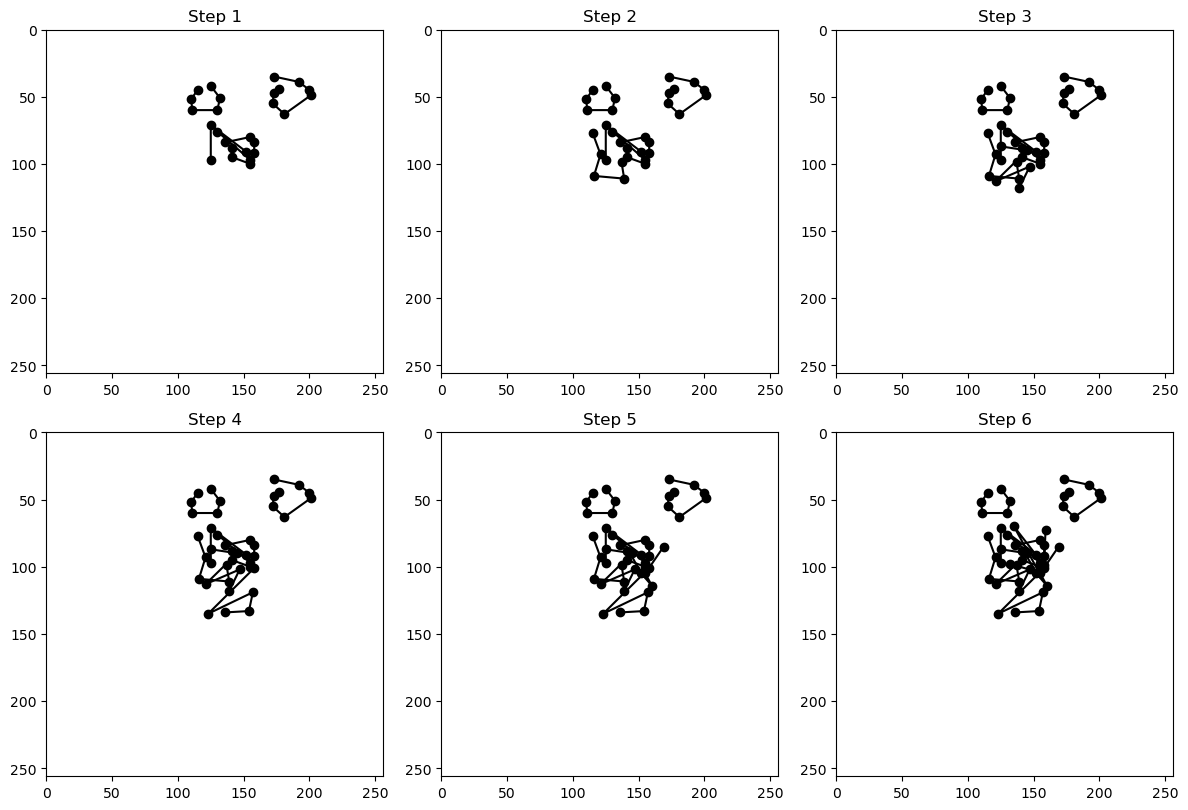

In [21]:

# 🔹 Grid Configuration
num_steps = min(len(predicted_strokes), 9)  # Show up to 9 steps
cols = 3
rows = (num_steps // cols) + 1

fig, axs = plt.subplots(rows, cols, figsize=(12, 12))

# Plot progression in a grid
for i in range(num_steps):
    step_strokes = input_strokes + predicted_strokes[:i+1]  # Include progressively more strokes
    row, col = divmod(i, cols)
    plot_drawing(axs[row, col], step_strokes, f"Step {i+1}")

# Hide extra empty plots
for j in range(num_steps, rows * cols):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

